In [1]:
#Importing required libraries
import random
import csv
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import re
from numba import jit, cuda

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as Func

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Downloading and Cloning INDICNLP
!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install Morfessor

# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES="/content/indic_nlp_resources"

fatal: destination path 'indic_nlp_library' already exists and is not an empty directory.
fatal: destination path 'indic_nlp_resources' already exists and is not an empty directory.


In [4]:
#Setting system path and environment variables
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))

from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)

#Load IndicNLP library
from indicnlp import loader
loader.load()

In [5]:
def remove_punctuations(text):

    text=text.replace('-',' ')
    text=text.replace('"',' ')
    text=text.replace('/',' ')
    text=text.replace('~',' ')
    text=text.replace('[',' ')
    text=text.replace(']',' ')
    text=text.replace('{',' ')
    text=text.replace('}',' ')
    text=text.replace('|',' ')
    text=text.replace('।',' ')
    text=re.sub('\s+',' ',text)

    return text

In [6]:
remove_punctuations("Hi....I'm Jay   Vora")

"Hi....I'm Jay Vora"

In [7]:
from indicnlp.tokenize import sentence_tokenize

#Splitting a hindi paragraph into hindi sentences
def SentenceSplitHindi(indic_string):
    
    indic_string = remove_punctuations(indic_string)
    
    sents = sentence_tokenize.sentence_split(indic_string, lang='hi')
    sent1 = []
    for s in sents:
        #some special cases in sentences where "()" and ":" were not splitted by indicnlp are splitted manually
        if ')' in s:
            splits = re.split("[?<=)]", s)
            sent1.append(splits[0]+')')
            for sp in range(1, len(splits) - 1):
                sent1.append(splits[sp][1:]+')')
            if (len(splits[-1][1:]) > 0):
                sent1.append(splits[-1][1:])
        else:
            sent1.append(s)

    sentences = []
    for s in sent1:
        if ':' in s:
            splits = re.split("[?<=:]", s)
            sentences.append(splits[0]+':')
            for sp in range(1, len(splits) - 1):
                sentences.append(splits[sp][1:]+':')

            if (len(splits[-1][1:]) > 0):
                sentences.append(splits[-1][1:])
        else:
            sentences.append(s)

    return sentences      


In [8]:
from indicnlp.tokenize import indic_tokenize  

#Tokenizing hindi sentences
def TokenizeHindi(indic_string):
    return indic_tokenize.trivial_tokenize(indic_string) 
 

In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

#Tokenizing English sentences
def TokenizeEnglish(text):
  return [token for token in word_tokenize(text)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
from nltk.tokenize import sent_tokenize
#Splitting a English paragraph into english sentences
def SentenceSplitEnglish(text):
    text = remove_punctuations(text)
    return [sent.strip() for sent in sent_tokenize(text)]

Language Class
-------------

In [11]:
SOS = 0 #Start of sentence
EOS = 1 #End of sentence
UNK = 2 #Unknown Word

#Language class to store the words in the training data
class Language:
    def __init__(self, Name):
        self.Name = Name
        self.WordToIndex = {}
        self.WordToCount = {}
        self.IndexToWord = {0: "SOS", 1: "EOS", 2:"UNK"}
        self.No_Of_Words = 3  # For SOS, EOS & UNK
 
    def AddSentence(self, sentence):
        if self.Name == "Hindi":
            tokens = TokenizeHindi(sentence)
        else:
            tokens = TokenizeEnglish(sentence)

        for word in tokens:
            if word not in self.WordToIndex:
                self.WordToIndex[word] = self.No_Of_Words
                self.WordToCount[word] = 1
                self.IndexToWord[self.No_Of_Words] = word
                self.No_Of_Words += 1
            else:
                self.WordToCount[word] += 1

Getting Training Data
--------------------

In [12]:
#Reading training data and generating pairs from it.
def ReadTrainingData(l1, l2):

    lines = []
    with open("drive/MyDrive/Colab Notebooks/NLP Competition/train.csv", 'r') as csvfile:
        csvreader = csv.reader(csvfile)

        for line in csvreader:
            lines.append(line)
    count = 0
    pairs = []
    #Generating pairs from training data
    for l in lines[1:]:
        hin_sents = SentenceSplitHindi(l[1])
        eng_sents = SentenceSplitEnglish(l[2])
        if (len(hin_sents)==len(eng_sents)):
            for s in range(len(hin_sents)):
                pairs.append([hin_sents[s], eng_sents[s]])

        else:
            count+=1 #Count for Discarded Pairs
    #pairs = [[l[1], l[2]] for l in lines[1:]]

    print("Discarded Pairs:" + str(count))

    #Creating language class objects for input and output languages
    I_lang = Language(l1)
    O_lang = Language(l2)

    print("Training Pairs Available: %s" % len(pairs)) #No. of training pairs available in training data

    #Adding sentences from training data into the language class objects
    for pair in pairs:
        I_lang.AddSentence(pair[0])
        O_lang.AddSentence(pair[1])
    print("Word Count:")
    print(I_lang.Name + " : " + str(I_lang.No_Of_Words))
    print(O_lang.Name + " : " + str(O_lang.No_Of_Words))

    return I_lang, O_lang, pairs


Input_lang, Output_lang, pairs = ReadTrainingData('Hindi', 'English')

Discarded Pairs:8398
Training Pairs Available: 94657
Word Count:
Hindi : 42213
English : 35657


In [13]:
def Find_Max(pairs):

    max_hin = 0
    max_eng = 0

    #Finding Maximum length of sentences in hindi and english
    for p in pairs:
        hin = TokenizeHindi(p[0])
        engl = TokenizeEnglish(p[1])
        if len(hin) > max_hin:
            max_hin = len(hin)

        if len(engl) > max_eng:
            max_eng = len(engl) 


    print("Maximum Sentece length in Hindi : " + str(max_hin)) 
    print("Maximum Sentece length in English : " + str(max_eng))   


Find_Max(pairs)

Maximum Sentece length in Hindi : 166
Maximum Sentece length in English : 168


Defining Neural Network Classes
-------------------------------

In [14]:
MAX_LENGTH = 175    #As seen above, Maximum sentence length  is less than 150, so I'd taken MAX_LENGTH = 150

In [15]:
#Encoder Class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers = 2, dropout = float(0.3)):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = dropout
        self.gru = nn.GRU(hidden_size, int(hidden_size/2) ,no_layers, dropout = dropout, bidirectional=True)

    #Forward function for encoder class
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def InitializeHidden(self):
        return torch.zeros(2*self.no_layers, 1, int(self.hidden_size/2), device=device)

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, no_layers = 2, dropout = float(0.3)):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, no_layers, dropout = dropout)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = Func.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.no_layers, 1, self.hidden_size, device=device)



**Training**
=============

In [18]:
#Generating Tensor for the input sentence
def SentenceTensor(lang, sentence):
    indexes = []
    for word in TokenizeHindi(sentence):
        if word not in lang.WordToIndex.keys():
            indexes.append(2) #If a word is not in the corpus while running test data assign a default index(UNK)
        else: 
            indexes.append(lang.WordToIndex[word])
    indexes.append(EOS)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

#Generating pair of Tensors for the pair of sentences
def PairTensor(pair):
    InputTensor = SentenceTensor(Input_lang, pair[0])
    TargetTensor = SentenceTensor(Output_lang, pair[1])
    return (InputTensor, TargetTensor)

Training the Model
------------------


In [24]:
TF_ratio = 0.5 # Teaching Forcing ratio parameter to apply teacher forcing randomly 

#Function to train one iteration for one pair of sentence
def TrainOne(InputTensor, TargetTensor, encoder, decoder, encoder_optimizer, decoder_optimizer, LossCriteria, max_length=MAX_LENGTH):
    en_hidden = encoder.InitializeHidden()

    #intializing zero gradients for both the optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = InputTensor.size(0)
    target_length = TargetTensor.size(0)

    en_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    #Calling encoder on the training instance
    for en_index in range(input_length):
        en_output, en_hidden = encoder(
            InputTensor[en_index], en_hidden)
        en_outputs[en_index] = en_output[0, 0]

    de_input = torch.tensor([[SOS]], device=device)

    bi_hidden = en_hidden.reshape(encoder.no_layers,1,encoder.hidden_size)
    de_hidden = bi_hidden

    #Taking a random input to decide that Teacher forcing will be used or not
    TeacherForcing = True if random.random() < TF_ratio else False

    if TeacherForcing:
        # Teacher forcing: Feeding the Actual target(as in the training pair) as the next input
        for de_index in range(target_length):
            # de_output, de_hidden, de_attention = decoder(de_input, de_hidden, en_outputs)
            de_output, de_hidden = decoder(de_input, de_hidden)

            loss += LossCriteria(de_output, TargetTensor[de_index])
            de_input = TargetTensor[de_index]  # Teacher forcing

    else:
        # Without Teacher forcing: Feeding its own predictions as the next input
        for de_index in range(target_length):
            # de_output, de_hidden, de_attention = decoder(de_input, de_hidden, en_outputs)
            de_output, de_hidden = decoder(de_input, de_hidden)

            topv, topi = de_output.topk(1)
            de_input = topi.squeeze().detach()

            loss += LossCriteria(de_output, TargetTensor[de_index])
            if de_input.item() == EOS:
                break

    #Calling Backward function
    loss.backward()

    #Updating the optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [20]:
#Function to Print Time consumed 
def TimeInMinutes(since):
    now = time.time()
    sec = now - since
    mins = math.floor(sec / 60)
    sec -= mins * 60

    return '%dmin %dsecs' % (mins, sec)

In [21]:
#Function for plotting the losses
def showPlot(points):
    plt.plot(points)

In [22]:
#Function for final training for all epochs
def FinalTraining(encoder, decoder, no_iters, print_every=5000, plot_every=500, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    TotalPrintLoss = 0  # Reset every print_every
    TotalPlotLoss = 0  # Reset every plot_every

    #Average SGD instead of simple SGD
    encoder_optimizer = optim.ASGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.ASGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [PairTensor(random.choice(pairs)) for i in range(no_iters)]

    #Poisson NLL Loss instead of Simple NLL Loss
    LossCriteria = nn.NLLLoss()

    for i in range(1, no_iters + 1):
        training_pair = training_pairs[i - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        #Computing loss for single training input
        loss = TrainOne(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, LossCriteria)
        
        TotalPrintLoss += loss
        TotalPlotLoss += loss

        if i % print_every == 0:
            print_loss_avg = TotalPrintLoss / print_every
            TotalPrintLoss = 0
            print('Time = %s (%d Iterations -- %d%%) Loss = %.4f' % (TimeInMinutes(start),
                                         i, i / no_iters * 100, print_loss_avg))

        if i % plot_every == 0:
            plot_loss_avg = TotalPlotLoss / plot_every
            plot_losses.append(plot_loss_avg)
            TotalPlotLoss = 0

    showPlot(plot_losses)

Calling FinalTraining() on every Training pair
-------------------------------------------------


Time = 2min 53secs (5000 Iterations -- 10%) Loss = 5.1005
Time = 5min 51secs (10000 Iterations -- 20%) Loss = 4.8127
Time = 8min 49secs (15000 Iterations -- 30%) Loss = 4.5909
Time = 11min 48secs (20000 Iterations -- 40%) Loss = 4.5137
Time = 14min 47secs (25000 Iterations -- 50%) Loss = 4.4030
Time = 17min 50secs (30000 Iterations -- 60%) Loss = 4.3509
Time = 20min 53secs (35000 Iterations -- 70%) Loss = 4.3040
Time = 23min 55secs (40000 Iterations -- 80%) Loss = 4.2246
Time = 26min 59secs (45000 Iterations -- 90%) Loss = 4.2095
Time = 30min 3secs (50000 Iterations -- 100%) Loss = 4.1361


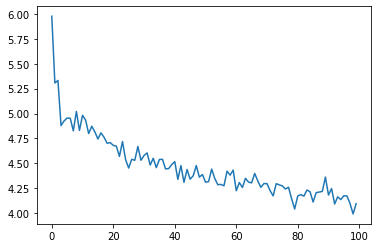

In [26]:
#Initialize Training Model
hidden_size = 300
encoder = Encoder(Input_lang.No_Of_Words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, Output_lang.No_Of_Words).to(device)

#I have trained 50000 epochs
FinalTraining(encoder, decoder, 50000, print_every=5000)

In [27]:
#Saving Encoder and Decoder models to Drive
torch.save(encoder, "drive/MyDrive/Colab Notebooks/NLP Competition/NLP_models/encoder5_0.pth")
torch.save(decoder, "drive/MyDrive/Colab Notebooks/NLP Competition/NLP_models/decoder5_0.pth")


In [28]:
#Loading Encoder model from Drive
encoder1 = torch.load("drive/MyDrive/Colab Notebooks/NLP Competition/NLP_models/encoder5_0.pth")
encoder1.eval()

Encoder(
  (embedding): Embedding(42213, 300)
  (gru): GRU(300, 150, num_layers=2, dropout=0.3, bidirectional=True)
)

In [29]:
#Loading Decoder model from Drive
decoder1 = torch.load("drive/MyDrive/Colab Notebooks/NLP Competition/NLP_models/decoder5_0.pth")
decoder1.eval()

DecoderRNN(
  (embedding): Embedding(35657, 300)
  (gru): GRU(300, 300, num_layers=2, dropout=0.3)
  (out): Linear(in_features=300, out_features=35657, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Translation 
-------------






In [30]:
#Function for Translating one sentence from Hindi to English basically for test dataset
def Translate_one(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = SentenceTensor(Input_lang, sentence)
        input_length = input_tensor.size()[0]
        en_hidden = encoder.InitializeHidden()

        en_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for en_index in range(input_length):
            en_output, en_hidden = encoder(input_tensor[en_index], en_hidden)
            en_outputs[en_index] += en_output[0, 0]

        de_input = torch.tensor([[SOS]], device=device)  # SOS

        bi_hidden = en_hidden.reshape(encoder.no_layers,1,encoder.hidden_size)        
        de_hidden = bi_hidden

        decoded_words = []
        de_attentions = torch.zeros(max_length, max_length)

        for de_index in range(max_length):
            de_output, de_hidden = decoder(de_input, de_hidden)
            topv, topi = de_output.data.topk(1)
            if topi.item() == EOS:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(Output_lang.IndexToWord[topi.item()])

            de_input = topi.squeeze().detach()

        return decoded_words 

Translating Training dataset
------------------------------

In [31]:
#Translating the test dataset
testlines = []
with open("drive/MyDrive/Colab Notebooks/NLP Competition/testhindistatements.csv", 'r') as testfile:
    testreader = csv.reader(testfile)

    for row in testreader:
        testlines.append(row)

inputs = [l[2] for l in testlines[1:]]

outfile = open("drive/MyDrive/Colab Notebooks/NLP Competition/NLP_models/answer5_0.txt", 'w+')

#For every input in test dataset call the function Translate_one() to translate every sentence into english
for i in range(len(inputs)):
    inp_sentences = SentenceSplitHindi(inputs[i])
    out_sentences = []
    for inp_sen in inp_sentences:
        output_words = Translate_one(encoder, decoder, inp_sen)
        out_sen = ' '.join(output_words[:-1])
        out_sentences.append(out_sen)
    output_sentence = ' '.join(out_sentences)
    outfile.write(output_sentence + "\n")
    
outfile.close()

Streaming output truncated to the last 5000 lines.
-मैं नहीं जा सकता।
I can ' t .
आ रही है और हम सब तैयार किया है किया जाना है. हो सकता है.
We have to go and we have to go to go . . . Can . . .
उस झगडे में बांह टूटने के बाद... ...चचाजान ने अयूब को खचर् दे दिया जिससे दोनों साथ काम कर सकें
The the ' s the . . . . . . . . . . . . . . . .
कुछ लोग शायद न माने लेकिन मुझे यकीन है कि ब्रोन्क्स नाकाम होने के लिए ही था।
But I knew that I knew but that they have to be . .
सावधानी से, वह चोट लगी है!
The , , , he !
मैं आपको ओमर के बारे में बताना चाहता हूं, एक पांच वर्षीय सीरियाई शरणार्थी लड़का जो लेसबोस तट पर एक भरी हुई रबड़ नाव पर पहुंचे।
I want to you on , you you to a , , , , , , on a
यह पहर टॉम 02: 00 है.
That ' ll the The is is . . .
मैराथन बडी हुई।
We ' re . . .
वो चार शब्द मेरे लिए उपहार थे।
He was me for . . .
डॉ. जॉनी न्यू यॉर्क में मैजिकल एनिमल्स के सीधे प्रसारण में विजेता की घोषणा करेंगे।
In the in in the the of of . . . .
उनकी जासूसों अपने करीबी सर्कल के अंदर कर रहे हैं... ... आप उनके ख

Reference Links:

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66

https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350

https://tsdaemon.github.io/2018/07/08/nmt-with-pytorch-encoder-decoder.html#model